<a href="https://colab.research.google.com/github/DhyeyMavani2003/DeepSentiment/blob/main/code/New_tokenization_and_naive_bayes_and_bert_model_train_val_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries for training, validating and testing the baseline model
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import BertTokenizer, BertModel
from transformers import AdamW, get_linear_schedule_with_warmup
import time
import os
import re
#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
df_train = pd.read_csv("https://raw.githubusercontent.com/DhyeyMavani2003/DeepSentiment/main/data/tweeteval/sentiment/csv/pre-token-train-data.csv")
df_val = pd.read_csv("https://raw.githubusercontent.com/DhyeyMavani2003/DeepSentiment/main/data/tweeteval/sentiment/csv/pre-token-val-data.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/DhyeyMavani2003/DeepSentiment/main/data/tweeteval/sentiment/csv/pre-token-test-data.csv")
print(df_train.head())


                                                Text  Label_ID Mapped_Label
0  qt user origin draft th book remu lupin surviv...         2     positive
1  ben smith smith concuss remain lineup thursday...         1      neutral
2  sorri bout stream last night crash tonight sur...         1      neutral
3  chase headley rbi doubl th inning david price ...         1      neutral
4  user alciato bee invest million januari anoth ...         2     positive


In [ ]:
# Trying Naive Bayes as a simpler model than BERT
from sklearn import preprocessing
X_train, y_train = df_train['Text'].values, df_train['Label_ID'].values
X_val, y_val = df_val['Text'].values, df_val['Label_ID'].values
X_test, y_test = df_test['Text'].values, df_test['Label_ID'].values
y_train_le = y_train.copy()
y_val_le = y_val.copy()
y_test_le = y_test.copy()
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = ohe.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_val.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train_le)
nb_pred = nb_clf.predict(X_test_tf)
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

TRAINING DATA: 45615
VALIDATION DATA: 2000
TESTING DATA: 12284
	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.81      0.05      0.10      3972
     Neutral       0.52      0.84      0.64      5937
    Positive       0.49      0.51      0.50      2375

    accuracy                           0.52     12284
   macro avg       0.61      0.47      0.42     12284
weighted avg       0.61      0.52      0.44     12284



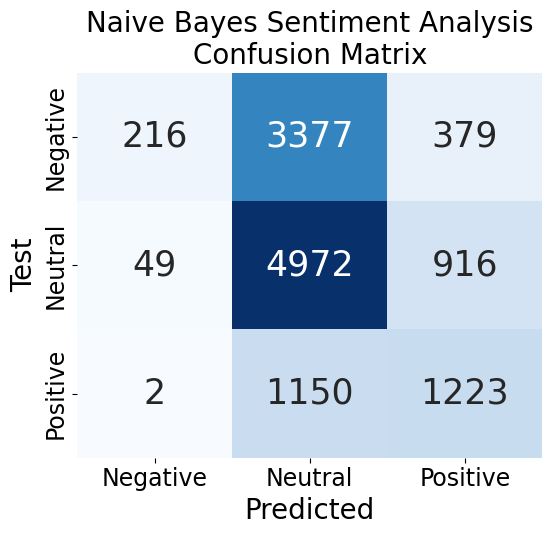

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def conf_matrix(y, y_pred, title):
  fig, ax =plt.subplots(figsize=(6,5))
  labels=['Negative', 'Neutral', 'Positive']
  ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
  plt.title(title, fontsize=20)
  ax.xaxis.set_ticklabels(labels, fontsize=17)
  ax.yaxis.set_ticklabels(labels, fontsize=17)
  ax.set_ylabel('Test', fontsize=20)
  ax.set_xlabel('Predicted', fontsize=20)
  plt.show()

conf_matrix(y_test.argmax(1), nb_pred,'Naive Bayes Sentiment Analysis\nConfusion Matrix')

In [ ]:
MAX_LEN=128
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def create_model(bert_model, max_len=MAX_LEN):
  ##params###
  opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
  loss = tf.keras.losses.CategoricalCrossentropy()
  accuracy = tf.keras.metrics.CategoricalAccuracy()

  input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
  embeddings = bert_model([input_ids,attention_masks])[1]

  output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
  model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
  model.compile(opt, loss=loss, metrics=accuracy)
  return model

model = create_model(bert_model, MAX_LEN)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_3[0][0]',             
 el)                         ngAndCrossAttentions(last_   40         'input_4[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                           

In [ ]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=2, batch_size=64)

result_bert = model.predict([test_input_ids,test_attention_masks])

y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

Epoch 1/2
713/713 [==============================] - 1137s 2s/step - loss: 0.8122 - categorical_accuracy: 0.6176 - val_loss: 0.7671 - val_categorical_accuracy: 0.6485
Epoch 2/2
384/384 [==============================] - 121s 288ms/step


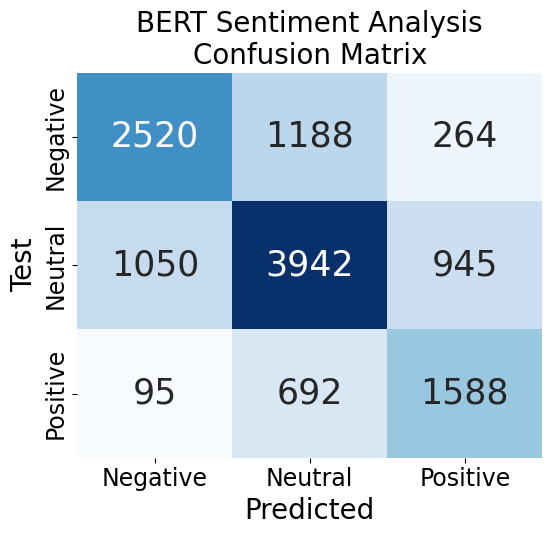

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.69      0.63      0.66      3972
     Neutral       0.68      0.66      0.67      5937
    Positive       0.57      0.67      0.61      2375

   micro avg       0.66      0.66      0.66     12284
   macro avg       0.64      0.66      0.65     12284
weighted avg       0.66      0.66      0.66     12284
 samples avg       0.66      0.66      0.66     12284



In [ ]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

In [ ]:
model.save("model_bert.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# roberta
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
print(max_length)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

49


In [ ]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

def create_model(bert_model, max_len=MAX_LEN):

    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

roberta_model = TFRobertaModel.from_pretrained('roberta-base')
model = create_model(roberta_model, MAX_LEN)
model.summary()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_5[0][0]',             
 aModel)                     ngAndCrossAttentions(last_   32         'input_6[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                           

384/384 [==============================] - 114s 270ms/step


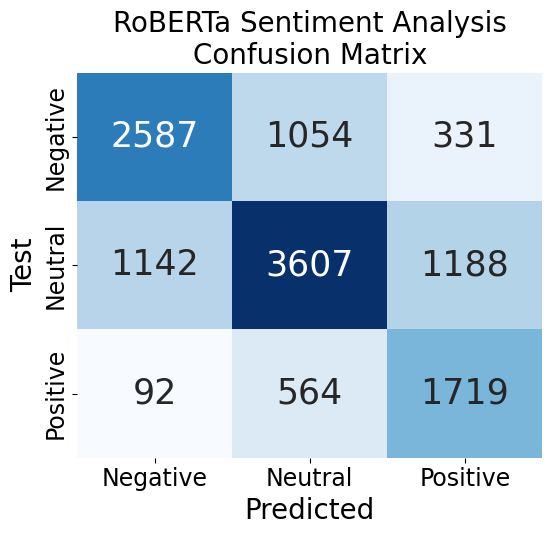

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       0.68      0.65      0.66      3972
     Neutral       0.69      0.61      0.65      5937
    Positive       0.53      0.72      0.61      2375

   micro avg       0.64      0.64      0.64     12284
   macro avg       0.63      0.66      0.64     12284
weighted avg       0.66      0.64      0.65     12284
 samples avg       0.64      0.64      0.64     12284



In [ ]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=1, batch_size=64)

result_roberta = model.predict([test_input_ids,test_attention_masks])
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

conf_matrix(y_test.argmax(1),y_pred_roberta.argmax(1),'RoBERTa Sentiment Analysis\nConfusion Matrix')
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

In [ ]:
model.save("model_roberta.keras")

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)
